In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-nefo5nii/granite-tsfm_422a6ae628af4f78870ee0009b679418
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-nefo5nii/granite-tsfm_422a6ae628af4f78870ee0009b679418
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

In [1]:

# 기존 numpy를 제거하고 다시 설치합니다.
!pip uninstall numpy -y
!pip install numpy


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 95.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
granite-tsfm 0.2.22 requires numpy<2, but you have numpy 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Granite TSFM 관련 라이브러리
from tsfm_public import TinyTimeMixerForPrediction
from transformers import TrainingArguments, Trainer
import torch

class PowerConsumptionPredictor:
    def __init__(self, model_name="ibm/TTM", context_length=512, forecast_length=96):
        """
        전력소비량 예측기 초기화

        Args:
            model_name: 사용할 모델명
            context_length: 입력 시퀀스 길이 (과거 데이터 길이)
            forecast_length: 예측 길이 (미래 예측할 포인트 수)
        """
        self.context_length = context_length
        self.forecast_length = forecast_length
        self.model = None
        self.scaler_dict = {}

    def load_and_preprocess_data(self, csv_path):
        """
        CSV 파일을 로드하고 전처리
        """
        # 데이터 로드
        df = pd.read_csv(csv_path)

        # 날짜/시간 컬럼 처리
        df['일시'] = pd.to_datetime(df['일시'])
        df = df.sort_values(['건물번호', '일시'])

        # 결측값 처리
        df = df.fillna(method='ffill').fillna(method='bfill')

        print(f"데이터 형태: {df.shape}")
        print(f"날짜 범위: {df['일시'].min()} ~ {df['일시'].max()}")
        print(f"건물 개수: {df['건물번호'].nunique()}")

        return df

    def prepare_features(self, df):
        """
        특성 준비 및 스케일링
        """
        # 시간 특성 추가
        df['hour'] = df['일시'].dt.hour
        df['day_of_week'] = df['일시'].dt.dayofweek
        df['month'] = df['일시'].dt.month
        df['day_of_year'] = df['일시'].dt.dayofyear

        # 특성 컬럼 정의
        weather_features = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
        time_features = ['hour', 'day_of_week', 'month', 'day_of_year']
        target_feature = ['전력소비량(kWh)']

        # 정규화
        from sklearn.preprocessing import StandardScaler

        # 각 특성 그룹별로 스케일러 적용
        scalers = {}

        for feature_group, features in [
            ('weather', weather_features),
            ('time', time_features),
            ('target', target_feature)
        ]:
            scalers[feature_group] = StandardScaler()
            df[features] = scalers[feature_group].fit_transform(df[features])

        self.scalers = scalers
        self.feature_columns = weather_features + time_features
        self.target_column = target_feature[0]

        return df

    def create_sequences(self, df, building_id=None):
        """
        시계열 시퀀스 생성
        """
        if building_id is not None:
            df_building = df[df['건물번호'] == building_id].copy()
        else:
            # 첫 번째 건물 사용
            building_id = df['건물번호'].iloc[0]
            df_building = df[df['건물번호'] == building_id].copy()

        df_building = df_building.sort_values('일시')

        # 특성과 타겟 분리
        features = df_building[self.feature_columns].values
        target = df_building[self.target_column].values

        # 시퀀스 생성
        X, y = [], []

        for i in range(len(df_building) - self.context_length - self.forecast_length + 1):
            # 입력: context_length만큼의 과거 데이터 (특성 + 타겟)
            past_features = features[i:i + self.context_length]
            past_target = target[i:i + self.context_length].reshape(-1, 1)

            # 과거 특성과 타겟을 결합
            past_data = np.concatenate([past_features, past_target], axis=1)

            # 예측할 미래 타겟
            future_target = target[i + self.context_length:i + self.context_length + self.forecast_length]

            X.append(past_data)
            y.append(future_target)

        return np.array(X), np.array(y), building_id

    def initialize_model(self, num_features):
        """
        TTM 모델 초기화
        """
        try:
            # TTM 모델 설정
            model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM",
                num_input_channels=num_features,
                context_length=self.context_length,
                prediction_length=self.forecast_length,
                ignore_mismatched_sizes=True
            )

            self.model = model
            print("TTM 모델이 성공적으로 로드되었습니다.")

        except Exception as e:
            print(f"모델 로드 중 오류 발생: {e}")
            print("대안 모델을 사용합니다.")

            # 간단한 대안 모델 (LSTM 기반)
            import torch.nn as nn

            class SimpleLSTMModel(nn.Module):
                def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=96):
                    super().__init__()
                    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
                    self.fc = nn.Linear(hidden_size, output_size)

                def forward(self, x):
                    lstm_out, _ = self.lstm(x)
                    output = self.fc(lstm_out[:, -1, :])  # 마지막 시간 스텝 사용
                    return output

            self.model = SimpleLSTMModel(num_features, output_size=self.forecast_length)

    def train_model(self, X_train, y_train, epochs=10):
        """
        모델 훈련
        """
        if isinstance(self.model, TinyTimeMixerForPrediction):
            # TTM 모델 훈련
            self._train_ttm(X_train, y_train, epochs)
        else:
            # LSTM 모델 훈련
            self._train_lstm(X_train, y_train, epochs)

    def _train_lstm(self, X_train, y_train, epochs):
        """
        LSTM 모델 훈련
        """
        import torch.nn as nn
        import torch.optim as optim

        # 데이터를 텐서로 변환
        X_tensor = torch.FloatTensor(X_train)
        y_tensor = torch.FloatTensor(y_train)

        # 훈련 설정
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # 훈련 루프
        self.model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()

            # 예측
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)

            # 역전파
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    def predict(self, X_test):
        """
        예측 수행
        """
        self.model.eval()

        with torch.no_grad():
            if isinstance(X_test, np.ndarray):
                X_tensor = torch.FloatTensor(X_test)
            else:
                X_tensor = X_test

            predictions = self.model(X_tensor)

            if isinstance(predictions, torch.Tensor):
                predictions = predictions.numpy()

        return predictions

    def inverse_transform_target(self, scaled_data):
        """
        타겟 변수 역변환
        """
        return self.scalers['target'].inverse_transform(scaled_data.reshape(-1, 1)).flatten()

    def plot_predictions(self, y_true, y_pred, title="전력소비량 예측 결과"):
        """
        예측 결과 시각화
        """
        plt.figure(figsize=(15, 8))

        # 여러 샘플이 있는 경우 처음 몇 개만 표시
        n_samples_to_plot = min(3, len(y_true))

        for i in range(n_samples_to_plot):
            plt.subplot(n_samples_to_plot, 1, i+1)

            # 실제값 역변환
            true_values = self.inverse_transform_target(y_true[i])
            pred_values = self.inverse_transform_target(y_pred[i])

            time_points = range(len(true_values))

            plt.plot(time_points, true_values, label='실제값', linewidth=2)
            plt.plot(time_points, pred_values, label='예측값', linewidth=2, linestyle='--')

            plt.title(f'{title} - 샘플 {i+1}')
            plt.xlabel('시간 (시간 단위)')
            plt.ylabel('전력소비량 (kWh)')
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# 사용 예제
def main():
    # 예측기 초기화
    predictor = PowerConsumptionPredictor(
        model_name="ibm-granite/granite-timeseries-ttm-r2",  # 이 부분만 수정
        context_length=168,  # 7일 (168시간)의 과거 데이터
        forecast_length=24   # 24시간 예측
    )

    # 데이터 로드 및 전처리
    print("데이터 로드 및 전처리 중...")
    df = predictor.load_and_preprocess_data('train.csv')  # CSV 파일 경로 수정
    df_processed = predictor.prepare_features(df)

    # 시퀀스 생성
    print("시퀀스 생성 중...")
    X, y, building_id = predictor.create_sequences(df_processed)
    print(f"생성된 시퀀스 수: {len(X)}")
    print(f"입력 형태: {X.shape}, 출력 형태: {y.shape}")

    # 훈련/테스트 분할
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # 모델 초기화 및 훈련
    print("모델 초기화 및 훈련 중...")
    predictor.initialize_model(X.shape[2])  # 특성 개수
    predictor.train_model(X_train, y_train, epochs=20)

    # 예측
    print("예측 수행 중...")
    y_pred = predictor.predict(X_test)

    # 결과 시각화
    predictor.plot_predictions(y_test, y_pred)

    # 성능 평가
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
    mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)

    print(f"\n성능 지표:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return predictor, y_test, y_pred

if __name__ == "__main__":
    # 필요한 라이브러리 설치
    print("필요한 라이브러리를 설치하세요:")
    print("pip install torch transformers scikit-learn matplotlib pandas numpy")
    print("pip install tsfm_public")

    # 실행
    predictor, y_test, y_pred = main()

필요한 라이브러리를 설치하세요:
pip install torch transformers scikit-learn matplotlib pandas numpy
pip install tsfm_public
데이터 로드 및 전처리 중...
데이터 형태: (204000, 10)
날짜 범위: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00
건물 개수: 100
시퀀스 생성 중...
생성된 시퀀스 수: 1849
입력 형태: (1849, 168, 11), 출력 형태: (1849, 24)
모델 초기화 및 훈련 중...


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm/TTM and are newly initialized because the shapes did not match:
- head.base_forecast_block.bias: found shape torch.Size([96]) in the checkpoint and torch.Size([24]) in the model instantiated
- head.base_forecast_block.weight: found shape torch.Size([96, 1024]) in the checkpoint and torch.Size([24, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TTM 모델이 성공적으로 로드되었습니다.


AttributeError: 'PowerConsumptionPredictor' object has no attribute '_train_ttm'

In [6]:
import pandas as pd
train_df = pd.read_csv('./train.csv')

In [7]:
train_df.head()

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25


전력소비량 예측 모델을 시작합니다...
예상 소요 시간: 10-15분

전력소비량 예측 모델 - 빠른 테스트 버전

1️⃣  데이터 로드 및 전처리
----------------------------------------
데이터 로딩 중...
원본 데이터 정보:
데이터 형태: (204000, 10)
건물번호 범위: 1 ~ 100
일시 샘플: 20240601 00 ~ 20240824 23
날짜/시간 파싱 중...
결측값 처리 중...

전처리 후 데이터 정보:
날짜 범위: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00
건물 개수: 100
각 건물별 데이터 포인트 수: 2040
특성 생성 중...
데이터 정규화 중...

특성 정보:
날씨 특성 (6개): ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
시간 특성 (5개): ['hour', 'day_of_week', 'month', 'day', 'is_weekend']
총 외생변수: 11개

2️⃣  시퀀스 생성
----------------------------------------
훈련용 건물: 10개 (ID: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)])
테스트용 건물: 5개 (ID: [np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)])

훈련 시퀀스 생성 중...
건물 1: 50개 시퀀스 생성
건물 2: 50개 시퀀스 생성
건물 3: 50개 시퀀스 생성
건물 4: 50개 시퀀스 생성
건물 5: 50개 시퀀스 생성
건물 6: 50개 시퀀스 생성
건물 7: 50개 시퀀스 생성
건물 8: 50개 시퀀스 생성
건물 9: 50개 시퀀스 생성
건물 10: 50개

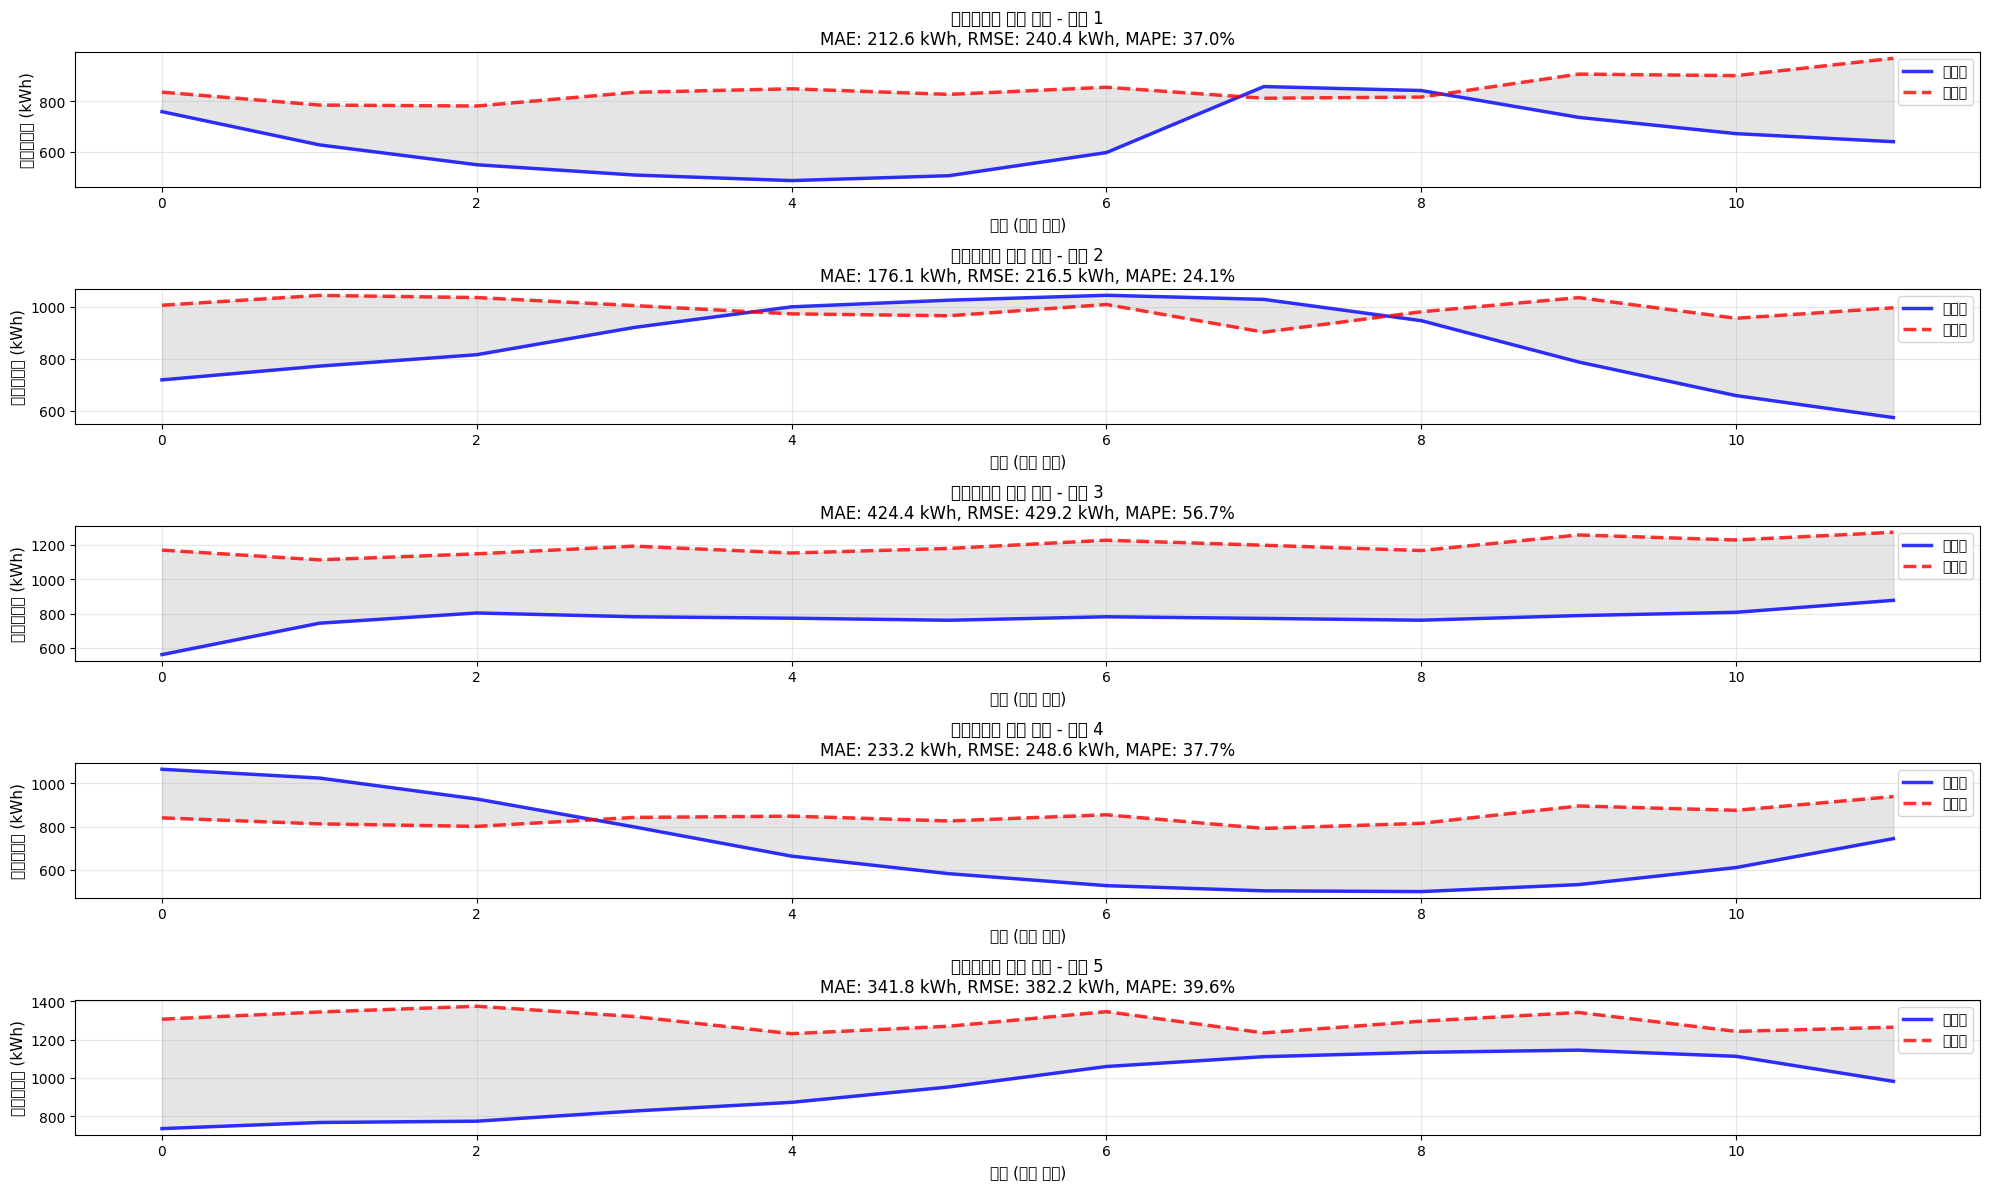

시각화 완료!

📊 최종 성능 지표:
테스트 건물: 5개 (ID: [np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)])
MAE (평균 절대 오차):     701.83 kWh
MSE (평균 제곱 오차):     885664.91 kWh²
RMSE (제곱근 평균 오차):  941.10 kWh
R² (결정 계수):          0.7775
MAPE (평균 절대 백분율 오차): 22.03%

🎉 모든 작업이 성공적으로 완료되었습니다!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

class PowerConsumptionPredictor:
    def __init__(self, model_name="ibm-granite/granite-timeseries-ttm-r2", context_length=72, forecast_length=12):
        """
        전력소비량 예측기 초기화 (빠른 버전)
        """
        self.model_name = model_name
        self.context_length = context_length
        self.forecast_length = forecast_length
        self.model = None
        self.scalers = {}
        self.is_ttm_model = False

    def parse_datetime(self, datetime_str):
        """
        '20240601 00' 형식의 문자열을 datetime으로 변환
        """
        try:
            return pd.to_datetime(datetime_str, format='%Y%m%d %H')
        except:
            return pd.to_datetime(datetime_str)

    def load_and_preprocess_data(self, csv_path):
        """
        CSV 파일을 로드하고 전처리
        """
        print("데이터 로딩 중...")
        df = pd.read_csv(csv_path)

        print("원본 데이터 정보:")
        print(f"데이터 형태: {df.shape}")
        print(f"건물번호 범위: {df['건물번호'].min()} ~ {df['건물번호'].max()}")
        print(f"일시 샘플: {df['일시'].iloc[0]} ~ {df['일시'].iloc[-1]}")

        # 날짜/시간 컬럼 처리
        print("날짜/시간 파싱 중...")
        df['datetime'] = df['일시'].apply(self.parse_datetime)
        df = df.sort_values(['건물번호', 'datetime'])

        # 결측값 처리
        print("결측값 처리 중...")
        numeric_columns = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
        df[numeric_columns] = df[numeric_columns].fillna(method='ffill').fillna(method='bfill')

        print(f"\n전처리 후 데이터 정보:")
        print(f"날짜 범위: {df['datetime'].min()} ~ {df['datetime'].max()}")
        print(f"건물 개수: {df['건물번호'].nunique()}")
        print(f"각 건물별 데이터 포인트 수: {len(df) // df['건물번호'].nunique()}")

        return df

    def prepare_features(self, df):
        """
        특성 준비 및 스케일링
        """
        print("특성 생성 중...")
        # 시간 특성 추가
        df['hour'] = df['datetime'].dt.hour
        df['day_of_week'] = df['datetime'].dt.dayofweek
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

        # 특성 그룹 정의
        weather_features = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
        time_features = ['hour', 'day_of_week', 'month', 'day', 'is_weekend']

        # 외생변수 (exogenous variables) = 날씨 + 시간 특성
        self.exog_features = weather_features + time_features
        self.target_feature = '전력소비량(kWh)'

        # 정규화
        print("데이터 정규화 중...")
        from sklearn.preprocessing import StandardScaler, MinMaxScaler

        # 각 특성별 스케일러
        self.scalers['weather'] = StandardScaler()
        self.scalers['time'] = MinMaxScaler()
        self.scalers['target'] = StandardScaler()

        # 스케일링 적용
        df[weather_features] = self.scalers['weather'].fit_transform(df[weather_features])
        df[time_features] = self.scalers['time'].fit_transform(df[time_features])
        df[[self.target_feature]] = self.scalers['target'].fit_transform(df[[self.target_feature]])

        print(f"\n특성 정보:")
        print(f"날씨 특성 ({len(weather_features)}개): {weather_features}")
        print(f"시간 특성 ({len(time_features)}개): {time_features}")
        print(f"총 외생변수: {len(self.exog_features)}개")

        return df

    def create_multivariate_sequences(self, df, building_ids=None, test_buildings=None, max_sequences_per_building=50):
        """
        다변량 시계열 시퀀스 생성 (최적화된 버전)
        """
        if building_ids is None:
            # 소규모 테스트: 10개 건물 훈련, 5개 건물 테스트
            all_buildings = sorted(df['건물번호'].unique())
            building_ids = all_buildings[:10]  # 처음 10개 건물만
            test_buildings = all_buildings[10:15]  # 다음 5개 건물

        print(f"훈련용 건물: {len(building_ids)}개 (ID: {building_ids})")
        print(f"테스트용 건물: {len(test_buildings)}개 (ID: {test_buildings})")

        def create_sequences_for_buildings(building_list, purpose="train"):
            all_past_values = []
            all_future_values = []
            total_sequences = 0

            for building_id in building_list:
                df_building = df[df['건물번호'] == building_id].sort_values('datetime').reset_index(drop=True)

                if len(df_building) < self.context_length + self.forecast_length:
                    print(f"건물 {building_id}: 데이터 부족 (길이: {len(df_building)})")
                    continue

                # 타겟 시계열 (전력소비량)
                target_values = df_building[self.target_feature].values

                # 외생변수 (날씨 + 시간 특성)
                exog_values = df_building[self.exog_features].values

                # 시퀀스 개수 제한 - 전체 가능한 시퀀스 중 일정 간격으로 샘플링
                max_possible = len(df_building) - self.context_length - self.forecast_length + 1
                step_size = max(1, max_possible // max_sequences_per_building)

                count = 0
                for i in range(0, max_possible, step_size):
                    if count >= max_sequences_per_building:
                        break

                    # 과거 데이터 (타겟 + 외생변수 결합)
                    past_target = target_values[i:i + self.context_length].reshape(-1, 1)
                    past_exog = exog_values[i:i + self.context_length]
                    past_combined = np.concatenate([past_target, past_exog], axis=1)

                    # 미래 타겟값
                    future_target = target_values[i + self.context_length:i + self.context_length + self.forecast_length]

                    all_past_values.append(past_combined)
                    all_future_values.append(future_target)
                    count += 1

                total_sequences += count
                print(f"건물 {building_id}: {count}개 시퀀스 생성")

            print(f"{purpose} 총 시퀀스: {total_sequences}개")
            return np.array(all_past_values), np.array(all_future_values)

        # 훈련 데이터 생성
        print("\n훈련 시퀀스 생성 중...")
        X_train, y_train = create_sequences_for_buildings(building_ids, "훈련")

        # 테스트 데이터 생성
        print("\n테스트 시퀀스 생성 중...")
        X_test, y_test = create_sequences_for_buildings(test_buildings, "테스트")

        print(f"\n시퀀스 생성 완료:")
        print(f"훈련 - 입력: {X_train.shape}, 출력: {y_train.shape}")
        print(f"테스트 - 입력: {X_test.shape}, 출력: {y_test.shape}")

        return X_train, y_train, X_test, y_test, building_ids, test_buildings

    def _create_small_lstm_model(self, input_features):
        """
        작고 빠른 LSTM 모델 생성
        """
        class SmallLSTM(nn.Module):
            def __init__(self, input_size, hidden_size=64, num_layers=2, forecast_length=12):
                super().__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers

                self.lstm = nn.LSTM(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    batch_first=True,
                    dropout=0.2 if num_layers > 1 else 0
                )

                self.fc_layers = nn.Sequential(
                    nn.Linear(hidden_size, hidden_size // 2),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(hidden_size // 2, forecast_length)
                )

            def forward(self, x):
                # LSTM
                lstm_out, _ = self.lstm(x)

                # 마지막 타임스텝 사용
                final_hidden = lstm_out[:, -1, :]

                # 예측
                output = self.fc_layers(final_hidden)

                return output

        self.model = SmallLSTM(
            input_size=input_features,
            hidden_size=64,
            num_layers=2,
            forecast_length=self.forecast_length
        )
        self.is_ttm_model = False

        # 모델 파라미터 수 출력
        total_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"소형 LSTM 모델 생성 완료 (파라미터 수: {total_params:,})")

    def initialize_model(self, input_features):
        """
        모델 초기화
        """
        print("소형 LSTM 모델을 생성합니다...")
        self._create_small_lstm_model(input_features)

    def train_model(self, X_train, y_train, epochs=30, batch_size=32):
        """
        모델 훈련 (진행률 표시 포함)
        """
        print(f"모델 훈련 시작...")
        print(f"  - Epochs: {epochs}")
        print(f"  - Batch size: {batch_size}")
        print(f"  - 입력 데이터: {X_train.shape}")
        print(f"  - 출력 데이터: {y_train.shape}")

        # 텐서 변환
        X_tensor = torch.FloatTensor(X_train)
        y_tensor = torch.FloatTensor(y_train)

        # 데이터 로더
        from torch.utils.data import TensorDataset, DataLoader
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        total_batches = len(dataloader)
        print(f"  - 에포크당 배치 수: {total_batches}")

        # GPU 사용 가능 여부 확인
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"  - 사용 디바이스: {device}")

        self.model = self.model.to(device)

        # 옵티마이저 및 손실함수
        optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        # 훈련 루프
        self.model.train()
        best_loss = float('inf')
        patience_counter = 0

        print(f"\n훈련 시작:")
        print("-" * 60)

        for epoch in range(epochs):
            total_loss = 0
            num_batches = 0

            # 에포크 진행률 표시
            for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                optimizer.zero_grad()

                try:
                    predictions = self.model(batch_X)
                    loss = criterion(predictions, batch_y)

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()

                    total_loss += loss.item()
                    num_batches += 1

                    # 진행률 표시 (매 10번째 배치마다)
                    if (batch_idx + 1) % 10 == 0:
                        progress = (batch_idx + 1) / total_batches * 100
                        print(f"  Epoch {epoch+1:2d}/{epochs} - 배치 {batch_idx+1:3d}/{total_batches} ({progress:5.1f}%) - Loss: {loss.item():.4f}", end='\r')

                except Exception as e:
                    print(f"\n배치 처리 중 오류: {e}")
                    continue

            if num_batches > 0:
                avg_loss = total_loss / num_batches
                scheduler.step(avg_loss)

                # 조기 종료 체크
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0
                    torch.save(self.model.state_dict(), 'best_power_model.pth')
                else:
                    patience_counter += 1

                # 에포크 완료 출력
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Epoch {epoch+1:2d}/{epochs} 완료 - 평균 Loss: {avg_loss:.6f} - LR: {current_lr:.2e} - 최고 Loss: {best_loss:.6f}")

                if patience_counter >= 10:
                    print(f"\n조기 종료 at epoch {epoch+1} (patience: {patience_counter})")
                    break

                if avg_loss < 1e-6:
                    print(f"\n수렴 완료 at epoch {epoch+1}")
                    break

        print("-" * 60)

        # 최고 모델 로드
        try:
            self.model.load_state_dict(torch.load('best_power_model.pth'))
            self.model = self.model.to(device)
            print("최고 성능 모델 로드 완료")
        except:
            print("저장된 모델을 찾을 수 없어 현재 모델을 사용합니다.")

    def predict(self, X_test):
        """
        예측 수행
        """
        print("예측 수행 중...")
        self.model.eval()
        device = next(self.model.parameters()).device

        predictions = []
        batch_size = 64

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                batch_X = X_test[i:i+batch_size]
                X_tensor = torch.FloatTensor(batch_X).to(device)

                batch_pred = self.model(X_tensor)
                predictions.append(batch_pred.cpu().numpy())

                # 진행률 표시
                progress = min(100, (i + batch_size) / len(X_test) * 100)
                print(f"예측 진행률: {progress:.1f}%", end='\r')

        print("예측 완료!                    ")
        return np.concatenate(predictions, axis=0)

    def inverse_transform_target(self, scaled_data):
        """
        타겟 변수 역변환
        """
        original_shape = scaled_data.shape
        if scaled_data.ndim > 1:
            scaled_data = scaled_data.reshape(-1, 1)
        else:
            scaled_data = scaled_data.reshape(-1, 1)

        result = self.scalers['target'].inverse_transform(scaled_data)
        return result.reshape(original_shape)

    def plot_predictions(self, y_true, y_pred, title="전력소비량 예측 결과", n_samples=5):
        """
        예측 결과 시각화
        """
        print("결과 시각화 중...")
        plt.figure(figsize=(20, 12))

        n_samples_to_plot = min(n_samples, len(y_true))

        for i in range(n_samples_to_plot):
            plt.subplot(n_samples_to_plot, 1, i+1)

            # 역변환
            true_values = self.inverse_transform_target(y_true[i]).flatten()
            pred_values = self.inverse_transform_target(y_pred[i]).flatten()

            time_points = range(len(true_values))

            plt.plot(time_points, true_values, label='실제값', linewidth=2.5, color='blue', alpha=0.8)
            plt.plot(time_points, pred_values, label='예측값', linewidth=2.5, linestyle='--', color='red', alpha=0.8)

            # 오차 영역 표시
            plt.fill_between(time_points, true_values, pred_values, alpha=0.2, color='gray')

            # 성능 지표
            mae = np.mean(np.abs(true_values - pred_values))
            mse = np.mean((true_values - pred_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((true_values - pred_values) / (true_values + 1e-8))) * 100

            plt.title(f'{title} - 샘플 {i+1}\nMAE: {mae:.1f} kWh, RMSE: {rmse:.1f} kWh, MAPE: {mape:.1f}%', fontsize=12)
            plt.xlabel('시간 (시간 단위)', fontsize=11)
            plt.ylabel('전력소비량 (kWh)', fontsize=11)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        print("시각화 완료!")

def main(csv_path):
    """
    메인 실행 함수 (최적화된 버전)
    """
    print("=" * 80)
    print("전력소비량 예측 모델 - 빠른 테스트 버전")
    print("=" * 80)

    # 예측기 초기화 (소규모 설정)
    predictor = PowerConsumptionPredictor(
        context_length=72,   # 3일 (72시간)
        forecast_length=12   # 12시간 예측
    )

    # 1. 데이터 로드 및 전처리
    print("\n1️⃣  데이터 로드 및 전처리")
    print("-" * 40)
    df = predictor.load_and_preprocess_data(csv_path)
    df_processed = predictor.prepare_features(df)

    # 2. 시퀀스 생성 (소규모)
    print("\n2️⃣  시퀀스 생성")
    print("-" * 40)
    X_train, y_train, X_test, y_test, train_buildings, test_buildings = predictor.create_multivariate_sequences(
        df_processed,
        max_sequences_per_building=50  # 건물당 최대 50개 시퀀스
    )

    # 훈련/검증 분할
    split_idx = int(0.8 * len(X_train))
    X_train_split = X_train[:split_idx]
    y_train_split = y_train[:split_idx]
    X_val = X_train[split_idx:]
    y_val = y_train[split_idx:]

    print(f"\n최종 데이터 분할:")
    print(f"  훈련: {X_train_split.shape}")
    print(f"  검증: {X_val.shape}")
    print(f"  테스트: {X_test.shape}")

    # 3. 모델 초기화
    print("\n3️⃣  모델 초기화")
    print("-" * 40)
    predictor.initialize_model(X_train.shape[2])

    # 4. 모델 훈련
    print("\n4️⃣  모델 훈련")
    print("-" * 40)
    predictor.train_model(X_train_split, y_train_split, epochs=30, batch_size=32)

    # 5. 예측
    print("\n5️⃣  예측 수행")
    print("-" * 40)
    y_pred = predictor.predict(X_test)

    # 6. 결과 시각화
    print("\n6️⃣  결과 분석")
    print("-" * 40)
    predictor.plot_predictions(y_test, y_pred)

    # 7. 성능 평가
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    y_test_orig = predictor.inverse_transform_target(y_test).flatten()
    y_pred_orig = predictor.inverse_transform_target(y_pred).flatten()

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / (y_test_orig + 1e-8))) * 100

    print(f"\n📊 최종 성능 지표:")
    print("=" * 50)
    print(f"테스트 건물: {len(test_buildings)}개 (ID: {test_buildings})")
    print(f"MAE (평균 절대 오차):     {mae:.2f} kWh")
    print(f"MSE (평균 제곱 오차):     {mse:.2f} kWh²")
    print(f"RMSE (제곱근 평균 오차):  {rmse:.2f} kWh")
    print(f"R² (결정 계수):          {r2:.4f}")
    print(f"MAPE (평균 절대 백분율 오차): {mape:.2f}%")
    print("=" * 50)

    return predictor, y_test, y_pred

# 실행
if __name__ == "__main__":
    print("전력소비량 예측 모델을 시작합니다...")
    print("예상 소요 시간: 10-15분")
    print()

    csv_path = 'train.csv'  # 실제 파일 경로로 변경하세요!

    try:
        predictor, y_test, y_pred = main(csv_path)
        print("\n🎉 모든 작업이 성공적으로 완료되었습니다!")

    except KeyboardInterrupt:
        print("\n❌ 사용자에 의해 중단되었습니다.")
    except Exception as e:
        print(f"\n❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()